<a href="https://colab.research.google.com/github/ppleum21z/Neural-Network-SMS-Text-Classifier/blob/main/Copy_of_fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
2.15.0-dev20230918


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-09-19 07:22:14--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.06s   

2023-09-19 07:22:15 (5.79 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-09-19 07:22:15--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
train_df = pd.read_table(train_file_path,header=None,names=['type' , 'msg'])
train_df.dropna()
train_df

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [ ]:
test_df = pd.read_table(test_file_path,header=None,names=['type' , 'msg'])
test_df.dropna()
test_df

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]
test_df

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?
...,...,...
1387,0,true dear..i sat to pray evening and felt so.s...
1388,0,"what will we do in the shower, baby?"
1389,0,where are you ? what are you doing ? are yuou ...
1390,1,ur cash-balance is currently 500 pounds - to m...


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices((train_df["msg"].values, train_labels))

test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices((test_df["msg"].values, test_labels))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vec = TextVectorization(output_mode='int',    max_tokens=1000,    output_sequence_length=1000,)

vec.adapt(train_ds.map(lambda text, label: text))


In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(len(vec.get_vocabulary()),64,mask_zero=True,    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='relu')
])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding_10 (Embedding)    (None, 1000, 64)          64000     
                                                                 
 bidirectional_17 (Bidirect  (None, 1000, 128)         66048     
 ional)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                     

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
131/131 [==============================] - 482s 4s/step - loss: 0.2217 - acc: 0.9397 - val_loss: 0.0786 - val_acc: 0.9812
Epoch 2/10
131/131 [==============================] - 449s 3s/step - loss: 0.2150 - acc: 0.9584 - val_loss: 0.0652 - val_acc: 0.9760
Epoch 3/10
131/131 [==============================] - 447s 3s/step - loss: 0.1990 - acc: 0.9459 - val_loss: 0.0655 - val_acc: 0.9802
Epoch 4/10
131/131 [==============================] - 447s 3s/step - loss: 0.0806 - acc: 0.9895 - val_loss: 0.0965 - val_acc: 0.9802
Epoch 5/10
131/131 [==============================] - 448s 3s/step - loss: 0.0682 - acc: 0.9919 - val_loss: 0.0942 - val_acc: 0.9833
Epoch 6/10
131/131 [==============================] - 447s 3s/step - loss: 0.0650 - acc: 0.9926 - val_loss: 0.1217 - val_acc: 0.9833
Epoch 7/10
131/131 [==============================] - 502s 4s/step - loss: 0.0618 - acc: 0.9940 - val_loss: 0.1205 - val_acc: 0.9833
Epoch 8/10
131/131 [==============================] - 557s 4s/step - 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 28s 640ms/step - loss: 0.1728 - acc: 0.9813
Test Loss: 0.17284944653511047
Test Accuracy: 0.9813218116760254


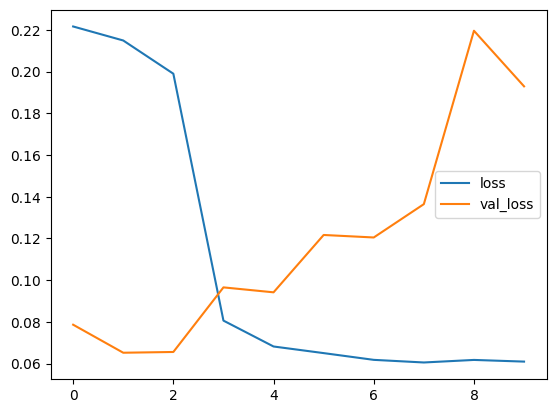

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

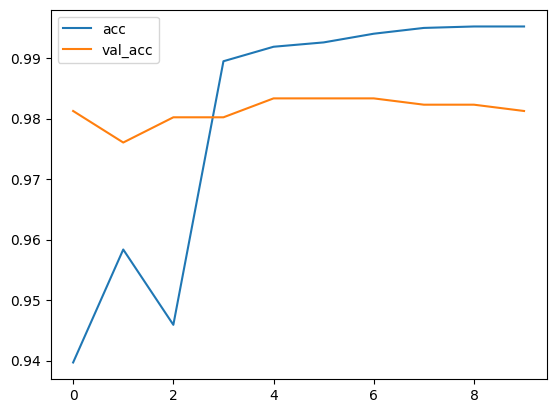

In [ ]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    prediction1 = model.predict([pred_text])
    return [prediction1[0][0], "ham" if prediction1[0][0] <0.5 else "spam"]


pred_text = "how are you doing today?"

prediction  = predict_message(pred_text)

1/1 [==============================] - 0s 241ms/step


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(prediction )
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 247ms/step
[0.0, 'ham']
1/1 [==============================] - 0s 237ms/step
[1.7032787, 'spam']
1/1 [==============================] - 0s 233ms/step
[0.0, 'ham']
1/1 [==============================] - 0s 248ms/step
[3.9314816, 'spam']
1/1 [==============================] - 0s 243ms/step
[3.9620683, 'spam']
1/1 [==============================] - 0s 255ms/step
[0.0, 'ham']
1/1 [==============================] - 0s 237ms/step
[0.0, 'ham']
You passed the challenge. Great job!


1/1 [==============================] - 0s 327ms/step
[0.1353261]
